# Exercise 6 - Unsupervised Learning & Sum Product Networks

## Overview
- Clustering 
    - K-Means
        - Overview and first examples
        - How to choose the parameter $K$
        - Why features matter
        - Why normalization and scaling matters
    - DBSCAN
        - Overview 
        - Examples 

### Installation of required packages

In [ ]:
!pip install numpy -q
!pip install matplotlib -q 
!pip install sklearn -q

In [ ]:
# Check all required packages
import matplotlib.pyplot as plt
import numpy as np
import sklearn 
import sklearn.datasets
from sklearn.cluster import KMeans, DBSCAN

from utils import * 

# $K$-Means Clustering
$K$-Means is a simple clustering algorithm that has a single hyperparameter: the number of possible clusters $K$.
The objective of the algorithm is to find a clustering that minimizes the squared distances to eahc cluster's center point (the mean of all datapoints in the cluster):

\begin{equation}
J = \sum _ { i = 1 } ^ { K } \sum _ { \mathbf { x } _ { j } \in S _ { i } } \left\| \mathbf { x } _ { j } - \boldsymbol { c_i } \right\| ^ { 2 }
\end{equation}

Given a fixed number $K$ of clusters, the algorithm starts with $K$ center points $c_i$ and iteratively repeats the following procedure:

1. Reassign all clusters to the cluster they have the minimum distance to (distance to the current center of the cluster)    
2. Recompute the centers of all clusters by computing the mean of all datapoints within each cluster

### Problems of Clustering Algorithms and $K$-Means
1. The algorithm generally suffers from the "curse of dimensionality", meaning that in high dimensional spaces the general idea of the algorithm might break: Semantic clusters are not necessarily neighbors in a metric sense and thus arbitrary clusterings can be the result of $K$-Means. 

2. Also choosing a decent start configuration for the center points $c_i$ is not always easy to obtain. Generally randomized starting points lead to usable results. Even multiple runs with different randomly chosen starting points might be an option.

3. A third difficulty is to chose a promising value $K$ for the possible clusters. This problem can be overcome by running $K$-Means with increasing numbers of $K$, stopping when the derivation of the naturally defined error (loss value) of $K$-Means vanishes.      

We start by generating random data to test the K-Means algorithm. Therefore the sklearn python package provides some data generators to understand the basic principles of clustering algorithms. If you want to easily test some algorithms on your own, you might have a look into these generator functions here:

https://scikit-learn.org/stable/modules/classes.html#module-sklearn.datasets

In [ ]:
# Seed for a pseudo random number generator (Linear Congruence Generator (LCG), Mersenne Twister, ...) within sklearn.
# With a fixed seed, you will always get the same random numbers when the generators are called. 
# Thus the generated datapoints look the same, even when the notebook is called multiple times. 
SEED=10

# Generate the first dataset (4 clusters, blob-like, mostly convex clusters)
data, labels = sklearn.datasets.make_blobs(n_samples=200, n_features=2, centers=4, cluster_std=1.2, random_state=SEED)

The first dataset mainly consists of convex "blob"-like structures that are dense within the clusters, but have a certain distance to other clusters.  

Let's have a look what $K$-Means does with the first dataset!

In [ ]:
fig = plt.figure(figsize=(6, 6))
drawScatter(data, labels)

This figure shows the ground truth data (colored by labels). Of course an unsupervised learning algorithms does not receive any labels during training, this means the algorithm gets the following as input data and has to assign labels itself.

In [ ]:
fig = plt.figure(figsize=(6, 6))
drawScatter(data, [])

In [ ]:
# Number of clusters K
kmeans = KMeans(n_clusters=2)

# Fitting the input data
kmeans = kmeans.fit(data)

# Getting the cluster labels
kmeans_predicted_labels = kmeans.predict(data)

# Centroid values
kmeans_final_centroids = kmeans.cluster_centers_

In [ ]:
fig = plt.figure(figsize=(6, 6))
drawScatterAndCentroids(data, kmeans_predicteds_labels, kmeans_final_centroids)

So the first clustering shows what we expected. $K$-Means makes a hard assignment of each given data point to a single cluster. Since we specified $K=2$ as target clusters, the result matches our intuition: the objection function of $K$-Means gets high, if within clusters there occur high distances to the cluster's center point. Since the four data-blobs are more far apart on the y-Axis than on the x-Axis, the objection of $K$-Means gets smaller when the two data-blobs on top are assigned to one cluster and the two blobs on the bottom are assigned to the second cluster.   

## Choosing the right value $K$

As we have seen, it is crucial to chose the right value for $K$, since it directly influences the quality of the clustering. Let's find a way to automate this!

### Exercise 1:
Clearly this clustering is not perfect. What value for $K$ leads to a good clustering in this  data? Play with different values for $K$ and show the results.

### Exercise 2
Think of a way to automatically chose a good value for the number of clusters $K$. Which quantity helps on this task?

As we see, there is major progress on the objection function when we increase the parameter $K$, but then when the optimal number of clusters is reached, the overall value does not improve dramatically anymore. This property can be used to automatically detect the correct number of clusters. To do so, we need a criterion when to stop the search for new clusters. A natural measure is the gradient of the error from the last step (or as you may call it the progress that has been made by increasing the parameter $K$ since the previous $K$). If this progress/gradient gets too small (smaller than our new parameter MINIMUM_PROGRESS), we stop the search for a good value of $K$. Let's try this out!

In [ ]:
MINIMUM_PROGRESS = 100.0

# Choose len(data) as the maximum number of clusters to search for. 
# In such a clustering, every datapoint has its own cluster. 
k_values = range(1, len(data))

# Add a variable to keep track of the last objection value.
last_objection_value = np.inf

# Add a variable to store the optimal cluster model 
optimal_model = None

# Try increasing values for the hyper-parameter K.
for K in k_values:
    
    # Number of clusters K, full is the EM-style K-Means algorithm
    kmeans = KMeans(n_clusters=K, algorithm='full')
    
    # Fitting the input data
    kmeans = kmeans.fit(data)

    # Getting the cluster labels
    kmeans_predicted_labels = kmeans.predict(data)

    # Centroid values
    kmeans_final_centroids = kmeans.cluster_centers_

    # Compute the clustering's objection value.
    objection_value = clusterObjectionKMeans(data, kmeans_predicted_labels, kmeans_final_centroids)
    
    # Compute the progress value as the different between the current objective and the last one.  
    progress = last_objection_value - objection_value
    if progress < MINIMUM_PROGRESS:
        print("Found optimal clustering with K = " + str(K - 1))
        break
    
    # If the termination criterion is not reached, 
    # save the current objection value for the next iteration
    last_objection_value = objection_value
    
    # Save the current model as the optimal model so far for the next iteration.
    optimal_model = kmeans
    
# Visualize the clustering of the optimal model:
# Getting the cluster labels
kmeans_predicted_labels = optimal_model.predict(data)

# Centroid values
kmeans_final_centroids = optimal_model.cluster_centers_

# Draw the clustering!
fig = plt.figure(figsize=(6, 6))
drawScatterAndCentroids(data, kmeans_predicted_labels, kmeans_final_centroids)

### Chosing the right feature space for clustering
So far we have seen that K-Means performs well on datasets that contain convex, "blob"-like clusters. The correct hyperparameter can be chosen in an automated fashion with a simple greedy search. Let's try our new algorithm on a second dataset. But before, let's put it in a python function to use it more conveniently: 

In [ ]:
def greedyKMeansClustering(data, MINIMUM_PROGRESS = 100.0):
    ''' Returns the optimal model, the objection values and the progress values from 
        a greedy search for good parameters K in a K-Means Clustering Algorithm.  
    '''
    
    # Choose len(data) as the maximum number of clusters to search for. 
    # In such a clustering, every datapoint has its own cluster. 
    k_values = range(1, len(data))

    # Add a variable to keep track of the last objection value.
    last_objection_value = np.inf

    # Add a variable to store the optimal cluster model 
    optimal_model = None
    
    # store the objection values and progress values in lists that get returned from the 
    # function with the optimal model 
    objection_values = []
    progress_values = []

    # Try increasing values for the hyper-parameter K.
    for K in k_values:
        # Number of clusters K, full is the EM-style K-Means algorithm
        kmeans = KMeans(n_clusters=K, algorithm='full')

        # Fitting the input data
        kmeans = kmeans.fit(data)

        # Getting the cluster labels
        kmeans_predicted_labels = kmeans.predict(data)

        # Centroid values
        kmeans_final_centroids = kmeans.cluster_centers_

        # Compute the clustering's objection value.
        objection_value = clusterObjectionKMeans(data, kmeans_predicted_labels, kmeans_final_centroids)
        
        # Compute the progress value as the different between the current objective and the last one.  
        progress = last_objection_value - objection_value
        
        # store the progress values and the objection values for later plotting.
        progress_values.append(progress)
        objection_values.append(objection_value)
        
        # Stoping criterium
        if progress < MINIMUM_PROGRESS:
            #Instead of printing success, return a tuple of the optimal model, 
            # the objections during trainign and the progress during training.!
            return (optimal_model, objection_values, progress_values)

        # If the termination criterion is not reached, 
        # save the current objection value for the next iteration
        last_objection_value = objection_value

        # Save the current model as the optimal model so far for the next iteration.
        optimal_model = kmeans

The second dataset is inherently different from the first one. The ground truth data contain two rings (with some gaussian noise) that lie within each other. Let's see what happens, when we apply $K$-Means to it.

In [ ]:
# Generate the second dataset (2 clusters, circular data)
data2, labels2 = sklearn.datasets.make_circles(n_samples=200, shuffle=True, noise=0.1, factor=0.5, random_state=SEED)
fig = plt.figure(figsize=(5, 5))
drawScatter(data2, labels2)

In [ ]:
# Call the cluster procedure.
opt_model, errors, progress = greedyKMeansClustering(data2, MINIMUM_PROGRESS=40.0)

kmeans_predicted_labels = opt_model.predict(data2)
kmeans_final_centroids = opt_model.cluster_centers_

# Plot the clustering result, the error and progress
fig, ax = plt.subplots(1, 2)
fig.set_figheight(5)
fig.set_figwidth(10)
plt.sca(ax[0])
drawScatterAndCentroids(data2, kmeans_predicted_labels, kmeans_final_centroids)
plt.sca(ax[1])
plt.plot(range(0, len(errors)), errors)
plt.plot(range(0, len(progress)), progress)

### Exercise 3
We see that our greedy search produces a clustering with $K=2$. Nevertheless it does not lead to a clustering that is very intuitive. What happens when we allow more clusters by tweeking MINIMUM_PROGRESS? Why is none of the gained clusterings good? What can we do to perform better?  

In [ ]:
feature_data = np.array([ np.sqrt((x_i ** 2 + y_i ** 2)) for (x_i, y_i) in data2 ]).reshape(-1, 1)

In [ ]:
fig = plt.figure(figsize=(6, 6))
plt.scatter(feature_data.reshape(-1,), [0] * feature_data.shape[0], c=labels2)

As we see, the data got transformed to features that are again "blob"-like. Thus $K$-Means should be able to find the correct clustering. Let's try it! 

In [ ]:
(labels, centroids) = clusterKMeans(feature_data, 2)

# Note that we plot the kmeans_predicted labels instead of the ground truth labels!
fig = plt.figure(figsize=(6, 6))
plt.scatter(feature_data, [0] * len(feature_data), c=labels)

This has worked properly! Now we just need to map the clustering result to the original data. 

In [ ]:
fig = plt.figure(figsize=(6, 6))
drawScatter(data2, labels)

### Why scaling and normalization is important 

Now let's look at a small variation of our previous dataset and apply a $K$-Means clustering with $K=4$

In [ ]:
data3, labels3 = genData3()

In [ ]:
fig = plt.figure(figsize=(6, 6))
drawScatter(data3, [])

In [ ]:
clusterKMeansAndPlot(data3, 4)

### Exercise 4 
What happened? The data seems very similar to the previous data, but the clustering algorithm got fooled completely. What is the reason for this? How can we solve this problem?

In [ ]:
fig = plt.figure(figsize=(10, 10))
plt.gca().set_aspect('equal')
drawScatter(data3, [])

This shows, why the clustering doesn't work very well. Since the X-Axis has a huge influence on the objective function, it is nearly irrelevant if the second axis gets clustered correctly. This means we have to ensure that all axes have approximately the same scope of values. We might use the standard deviations (on X-Values and on Y-Values) to scale the data.

In [ ]:
x_stdev = np.std(data3[:,0])
y_stdev = np.std(data3[:,1])
print(x_stdev, y_stdev)

While the standard deviation on the x-axis is rather small, the y-axis is stretched, which leads to a malfunctioning clustring algorithm. To overcome the problem, we have to scale all axis accordingly, so that each axis has approximately the same value scope. An easy way to do so, is to scale each axis by its standard deviation, which we already computed for our analysis.

In [ ]:
# Rescale all values on x and y axis by the referring standard deviation of the data.
# This leads to nice, "circle-like" structures in the data that can be clustered well.
data3_scaled = np.empty(data3.shape)
data3_scaled[:,0] = data3[:,0] / x_stdev
data3_scaled[:,1] = data3[:,1] / y_stdev

In [ ]:
(labels, centroids_scaled) = clusterKMeans(data3_scaled, 4)

fig = plt.figure(figsize=(6, 6))
drawScatter(data3, labels)

Again, the centroids are meaningless, since the clustering happened in the scaled space. If we want to plot the centroids, we have to scale them as well (which is not necessary, but nice for visualization purposes):

In [ ]:
centroids = np.empty(centroids_scaled.shape)
centroids[:,0] = centroids_scaled[:,0] * x_stdev
centroids[:,1] = centroids_scaled[:,1] * y_stdev

fig = plt.figure(figsize=(6, 6))
drawScatterAndCentroids(data3, labels, centroids)

## DBSCAN - Density-Based Spatial Clustering of Applications with Noise

DBSCAN is a different clustering algorithm that is based on the concept of density and density reachability. DBSCAN separates between three types of points/objects:

#### core points 
a datapoint p is called a core point, if at least $\mathcal{minpts}$ points are within distance $\epsilon$ of p 

#### (density-)reachable points 
a point that is in the neighborhood of a core point, but might have less than $\mathcal{minpts}$ points in its neighborhood $\epsilon$.

#### outliers 
All points that are not (density-)reachable are outliers.

#### Example [WIKI](https://en.wikipedia.org/wiki/DBSCAN)
The following example shows the clustering for $\mathcal{minpts}=4$
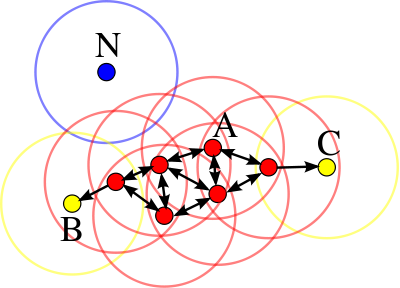


Thus, DBSCAN has two hyperparameters that can be tweaked:

1. **$\epsilon$**, the neighborhood radius of points.
2. **$\mathcal{minPts}$**, the number of points the neighborhood of point p must contain (inclusive p itself) that p is a core point.

Additionally the distance function that is used in DBSCAN can be chosen.

### Algorithm

1. Find all points in the $\epsilon$ neighborhood for each point, and identify the core points (all points with more than minPts neighbors in their $\epsilon$ neighborhood).

2. Find the connected components of core points on the neighbor graph (edges correspond to a core-neighboring relationship), ignoring all non-core points. 

3. Assign each non-core point a cluster that is an $\epsilon$ neighbor (they might be mutliple, choose one) If there is no such neighbor, assign the cluster to "noise"

### Properties and advatanges over $K$-Means
1. Arbitrary number of clusters possible, has not to be known a priori
2. Clusters of arbitrary shapes can be found
3. Robust to outliers
4. ''Interpretable'' hyperparameters $\epsilon$ and $\mathcal{minpts}$  

Let's examine how DBSCAN behaves on our previous datasets:

In [ ]:
fig = plt.figure(figsize=(6, 6))
clusterDBSCANAndPlot(data, epsilon=2.0, minpts=10)

In [ ]:
fig = plt.figure(figsize=(6, 6))
clusterDBSCANAndPlot(data2, epsilon=0.2, minpts=3)

In [ ]:
fig = plt.figure(figsize=(6, 6))
clusterDBSCANAndPlot(data3, epsilon=5.0, minpts=10.0)

### Exercise 5
Run DBScan on our previous datasets (data, data2, data3) and try different configurations of $\epsilon$ and $\mathcal{minpts}$.